In [1]:
# Import packages
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pickle
import math as math
from matplotlib import gridspec
import os
import seaborn as sns
%matplotlib inline
import pandas as pd
from scipy import stats

In [27]:
#Set figure style

%matplotlib inline
plt.style.use("seaborn-white")
# plt.rcParams['figure.figsize'] = [6.0, 4.0]
plt.rcParams['axes.titlesize'] = 8
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['legend.fontsize'] = 6
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = 'Arial'
colors = [i['color'] for i in plt.rcParams['axes.prop_cycle']]
plt.rcParams["figure.dpi"] = 200
plt.rcParams['grid.color'] = 'white'

In [3]:
# Load model functions
def signal_periodic(signal_number,t,slope_on,slope_off):
    p = signal_number
    if (p/2)*slope_on < 1:
        maxs = (p/2)*slope_on
    else:
        maxs = 1
        
    if signal_number == 0:
        return 0
    elif signal_number == 1:
        if t < 1/slope_on:
            return t*slope_on
        else:
            return 1
    else :
        it = math.floor(t/signal_number)
        if t>=it*p and t < it*p+p/2:
            if t >= it*p and t < it*p+(1/slope_on):
                return ((t-it*p)*slope_on)
            else:
                return 1
        else:
            return 0
def signal_single(signal_number,t,slope_on,slope_off):
    p = signal_number
    if (p)*slope_on < 1:
        maxs = (p)*slope_on
    else:
        maxs = 1
        
    if signal_number == 0:
        return 0
    elif signal_number == 1:
        if t < 1/slope_on:
            return t*slope_on
        else:
            return 1
    else :
        if t < p:
            if t <= p and t < (1/slope_on):
                return ((t)*slope_on)
            else:
                return 1
        else:
            return 0
            
def DE_periodic(y,t,signal_number,slope_on,slope_off):
    GFP, Fus3, ppFus3, Ste12, Ste12Digs, Far1, pFar1 = y

    s=signal_periodic(signal_number,t,slope_on,slope_off)

    # GFP
    dGFPdt = ksynGFP+(ka4*Ste12**hc)/(KGFP+Ste12**hc)-kdegGFP*GFP
    # Fus3
    dFus3dt = ksynF3+(kfb1*Ste12**hc)/(KFus3+Ste12**hc)-kp1*s*Fus3+kp2*ppFus3-kdegF3*Fus3
    # ppFus3
    dppFus3dt = kp1*s*Fus3-kp2*ppFus3
    # Ste12
    dSte12dt = ksynS12+(kfb2*Ste12**hc)/(KSte12+Ste12**hc)-kdegS12*Ste12*(1+(kff*pFar1)/(km1+pFar1))-ka1*Ste12*(DigsT-Ste12Digs)+(ka2*ppFus3+ka3)*Ste12Digs
    # Ste12Digs
    dSte12Digsdt = ka1*Ste12*(DigsT-Ste12Digs)-(ka2*ppFus3+ka3+kdegS12D)*Ste12Digs
    # Far1
    dFar1dt = ksynF1+(ka5*Ste12**hc)/(KFar1+Ste12**hc)+kp3*pFar1-kp4*ppFus3*Far1-kdegF1*Far1
    # pFar1
    dpFar1dt = kp4*ppFus3*Far1-kp3*pFar1-kdegPF1*pFar1

    return [dGFPdt, dFus3dt, dppFus3dt, dSte12dt, dSte12Digsdt, dFar1dt, dpFar1dt]
def DE_single(y,t,signal_number,slope_on,slope_off):
    GFP, Fus3, ppFus3, Ste12, Ste12Digs, Far1, pFar1 = y

    s=signal_single(signal_number,t,slope_on,slope_off)

    # GFP
    dGFPdt = ksynGFP+(ka4*Ste12**hc)/(KGFP+Ste12**hc)-kdegGFP*GFP
    # Fus3
    dFus3dt = ksynF3+(kfb1*Ste12**hc)/(KFus3+Ste12**hc)-kp1*s*Fus3+kp2*ppFus3-kdegF3*Fus3
    # ppFus3
    dppFus3dt = kp1*s*Fus3-kp2*ppFus3
    # Ste12
    dSte12dt = ksynS12+(kfb2*Ste12**hc)/(KSte12+Ste12**hc)-kdegS12*Ste12*(1+(kff*pFar1)/(km1+pFar1))-ka1*Ste12*(DigsT-Ste12Digs)+(ka2*ppFus3+ka3)*Ste12Digs
    # Ste12Digs
    dSte12Digsdt = ka1*Ste12*(DigsT-Ste12Digs)-(ka2*ppFus3+ka3+kdegS12D)*Ste12Digs
    # Far1
    dFar1dt = ksynF1+(ka5*Ste12**hc)/(KFar1+Ste12**hc)+kp3*pFar1-kp4*ppFus3*Far1-kdegF1*Far1
    # pFar1
    dpFar1dt = kp4*ppFus3*Far1-kp3*pFar1-kdegPF1*pFar1

    return [dGFPdt, dFus3dt, dppFus3dt, dSte12dt, dSte12Digsdt, dFar1dt, dpFar1dt]
def simulate_periodic_experiment(arr_parameters, time, signal_val,SS):
    # parameters to be learned
    kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D = arr_parameters
    # parameters to be kept constant
    kdegGFP = 10**-1
    hc = 1
    #solve odes:
    odes = odeint(DE_periodic, SS, time, args=(signal_val,slope_on,slope_off,))
    # return array of individual cell counts:
    return odes
def simulate_singlepulse_experiment(arr_parameters, time, signal_val,SS):
    # parameters to be learned
    kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D = arr_parameters
    # parameters to be kept constant
    kdegGFP = 10**-1
    hc = 1
    #solve odes:
    odes = odeint(DE_single, SS, time, args=(signal_val,slope_on,slope_off,))
    # return array of individual cell counts:
    return odes

In [16]:
# Import 50nM periodic data
filename = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/Mating-Model/Data/Experimental Data/50periodic_scaled.pickled'
data_to_score_against = filename
with open(filename, 'rb') as f:
    syntheticdata = pickle.load(f)
periodic50_time, periodic50_data = syntheticdata

In [17]:
# Import 10nM periodic data
filename = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/Mating-Model/Data/Experimental Data/10periodic_scaled.pickled'
data_to_score_against = filename
with open(filename, 'rb') as f:
    syntheticdata = pickle.load(f)
periodic10_time, periodic10_data = syntheticdata

In [18]:
# Import 50nM pulse data
filename = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/Mating-Model/Data/Experimental Data/50pulse_scaled.pickled'
data_to_score_against = filename
with open(filename, 'rb') as f:
    syntheticdata = pickle.load(f)
pulse50_time, pulse50_data = syntheticdata

In [25]:
# Periodic data - not shifted
filename = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/modelingEA/experimentaldata_scaled.pickled'
data_to_score_against = filename
with open(filename, 'rb') as f:
    syntheticdata = pickle.load(f)
periodic_time, periodic_data = syntheticdata

In [19]:
# Function to load data
def load_data(dir_path_data, score_cutoff):
    #MSE threshold score at which to not include 
    val_to_keep_end_score = score_cutoff
    
    #load new data:
    arr_best_scores = []
    arr_best_inds = []
    arr_end_scores = []
    dir_to_check = dir_path_data #'/home/iammoresentient/phd_lab/170307_data_sin_y1'
    files = os.listdir(dir_to_check)
    for i in range(0,len(files)):
        filename = dir_to_check + '/' + files[i]
        if os.path.isfile(filename):
            if os.path.getsize(filename) > 0: 
                if '.pickled' in files[i]:
                    #print(filename)
                    arr_to_unpickle = pickle.load(open(filename,'rb'))
                    arr_best_score, arr_best_ind = arr_to_unpickle
                    temp_end_score = arr_best_score[-1]
                    if temp_end_score < val_to_keep_end_score:
                        arr_end_scores.append(temp_end_score)
                        arr_best_scores.append(arr_best_score)
                        arr_best_inds.append(arr_best_ind)


    print('Loaded ' + str(len(arr_best_scores)) + ' files (out of ' + str(len(files)) + ') with cutoff score of ' + str(score_cutoff))

    #convert to numpy
    arr_best_scores = np.asarray(arr_best_scores)
    arr_best_inds = np.asarray(arr_best_inds)
    arr_end_scores = np.asarray(arr_end_scores)

    return arr_best_scores, arr_end_scores, arr_best_inds

In [20]:
# Load data
directory = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/Mating-Model/Data/Full Model/Digs Degradation/190101_ImmediateOff2mut_100g500i10m50c/'
arr_best_scores_P, arr_end_scores_P, arr_best_inds_P=load_data(directory,1.38)
arrT_best_inds_P = arr_best_inds_P.transpose()
# directory = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/Mating-Model/Data/Full Model/Digs Degradation/181230_TwoMutants_100g500i10m50c/'
# arr_best_scores_P, arr_end_scores_P, arr_best_inds_P=load_data(directory,1.6)
# arrT_best_inds_P = arr_best_inds_P.transpose()

Loaded 14 files (out of 572) with cutoff score of 1.38


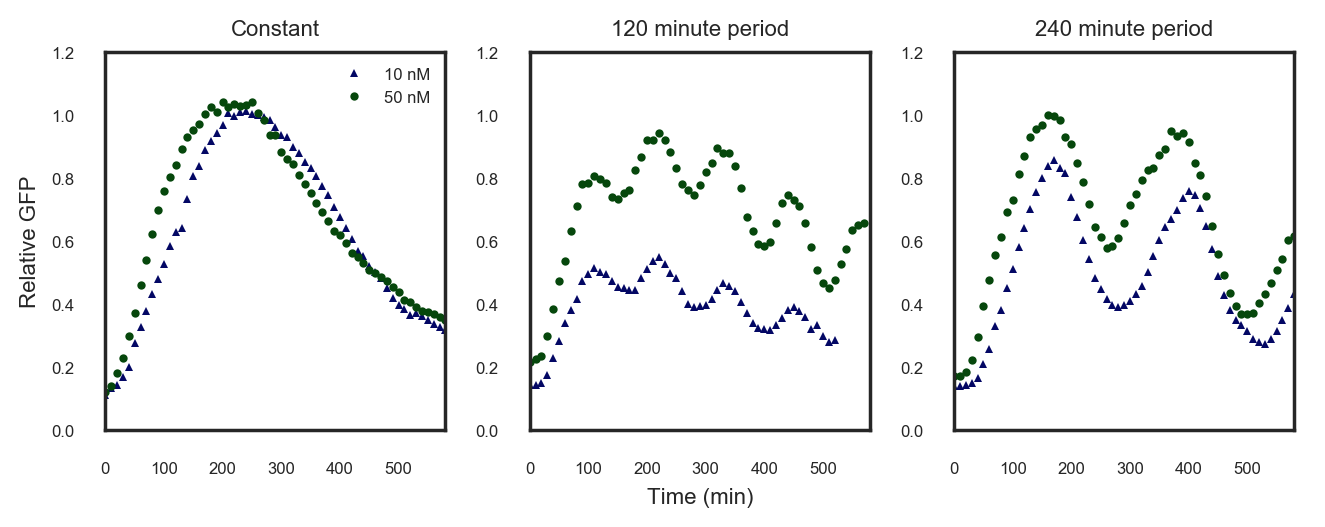

In [38]:
# plot
gen = 100

fig = plt.figure(figsize=(7, 3))
gs = gridspec.GridSpec(1,3)
A = fig.add_subplot(gs[:,0])
B = fig.add_subplot(gs[:,1])
C = fig.add_subplot(gs[:,2])
ax = fig.add_subplot(gs[:,:])

# remove figure markings
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
ax.set_facecolor('none')
ax.grid('off')

# # #50nM
# hc=2
# kdegGFP=10**-1
# time = np.linspace(0,570,571)
# SS=[]
# for j in range(len(arr_best_scores_P)):
#     kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D = arr_best_inds_P[j][gen]
#     IC = [0,0,0,0,0,0,0]
#     t  = np.linspace(0,40000,100001)
#     odes = odeint(DE_periodic, IC, t, args=(0,100,100,))
#     SS.append(odes[100000,:])

# for j in range(len(arr_best_scores_P)):
#     kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D = arr_best_inds_P[j][gen]
#     for i in [120,240]:
#         expX = simulate_periodic_experiment(arr_best_inds_P[j][gen], time, i,SS[j])
#         if i == 120:
#             B.plot(time, expX[:,0],color='xkcd:apple',alpha=0.25,linewidth=0.6)
#         elif i == 240: 
#             C.plot(time, expX[:,0],color='xkcd:apple',alpha=0.25,linewidth=0.6)
#     expX = simulate_periodic_experiment(arr_best_inds_P[j][gen], time, 1,SS[j])
#     A.plot(time, expX[:,0],color='xkcd:apple',alpha=0.25,linewidth=0.6)

# # #10nM
# hc=2
# kdegGFP=10**-1
# time = np.linspace(0,570,571)
# SS=[]
# for j in range(len(arr_best_scores_P)):
#     kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D = arr_best_inds_P[j][gen]
#     slope_on = slope_on*0.3
#     params = [kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D]
#     IC = [0,0,0,0,0,0,0]
#     t  = np.linspace(0,40000,100001)
#     odes = odeint(DE_periodic, IC, t, args=(0,100,100,))
#     SS.append(odes[100000,:])

# for j in range(len(arr_best_scores_P)):
#     kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D = arr_best_inds_P[j][gen]
#     slope_on = slope_on*0.3
#     params = [kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D]
#     for i in [120,240]:
#         expX = simulate_periodic_experiment(params, time, i,SS[j])
#         if i == 120:
#             B.plot(time, expX[:,0],color='xkcd:bluish',alpha=0.25,linewidth=0.6)
#         elif i == 240: 
#             C.plot(time, expX[:,0],color='xkcd:bluish',alpha=0.25,linewidth=0.6)
#     expX = simulate_periodic_experiment(params, time, 1,SS[j])
#     A.plot(time, expX[:,0],color='xkcd:bluish',alpha=0.25,linewidth=0.6)

xmax = 580

scorefxn_time = periodic10_time
scorefxn_data = periodic10_data
B.plot(scorefxn_time[2], scorefxn_data[2], '^', color='xkcd:darkblue', linewidth = 0, markersize=3)
B.axis([0, xmax, 0, 1.2])
C.plot(scorefxn_time[5], scorefxn_data[5], '^', color='xkcd:darkblue', linewidth = 0, markersize=3)
C.axis([0, xmax, 0, 1.2])
A.plot(scorefxn_time[0], scorefxn_data[0], '^', color='xkcd:darkblue', linewidth = 0, markersize=3)
A.axis([0, xmax, 0, 1.2])

scorefxn_time = periodic_time
scorefxn_data = periodic_data
B.plot(scorefxn_time[2], scorefxn_data[2], 'o', color='xkcd:forest green', linewidth = 0, markersize=3)
B.axis([0, xmax, 0, 1.2])
C.plot(scorefxn_time[5], scorefxn_data[5], 'o', color='xkcd:forest green', linewidth = 0, markersize=3)
C.axis([0, xmax, 0, 1.2])
A.plot(scorefxn_time[0], scorefxn_data[0], 'o', color='xkcd:forest green', linewidth = 0, markersize=3)
A.axis([0, xmax, 0, 1.2])

A.set_ylabel('Relative GFP')
ax.set_xlabel('Time (min)')

A.set_title('Constant')
B.set_title('120 minute period')
C.set_title('240 minute period')

A.legend(['10 nM', '50 nM'])

fig.tight_layout()

plt.savefig('Low Dose Data.png',dpi=600)

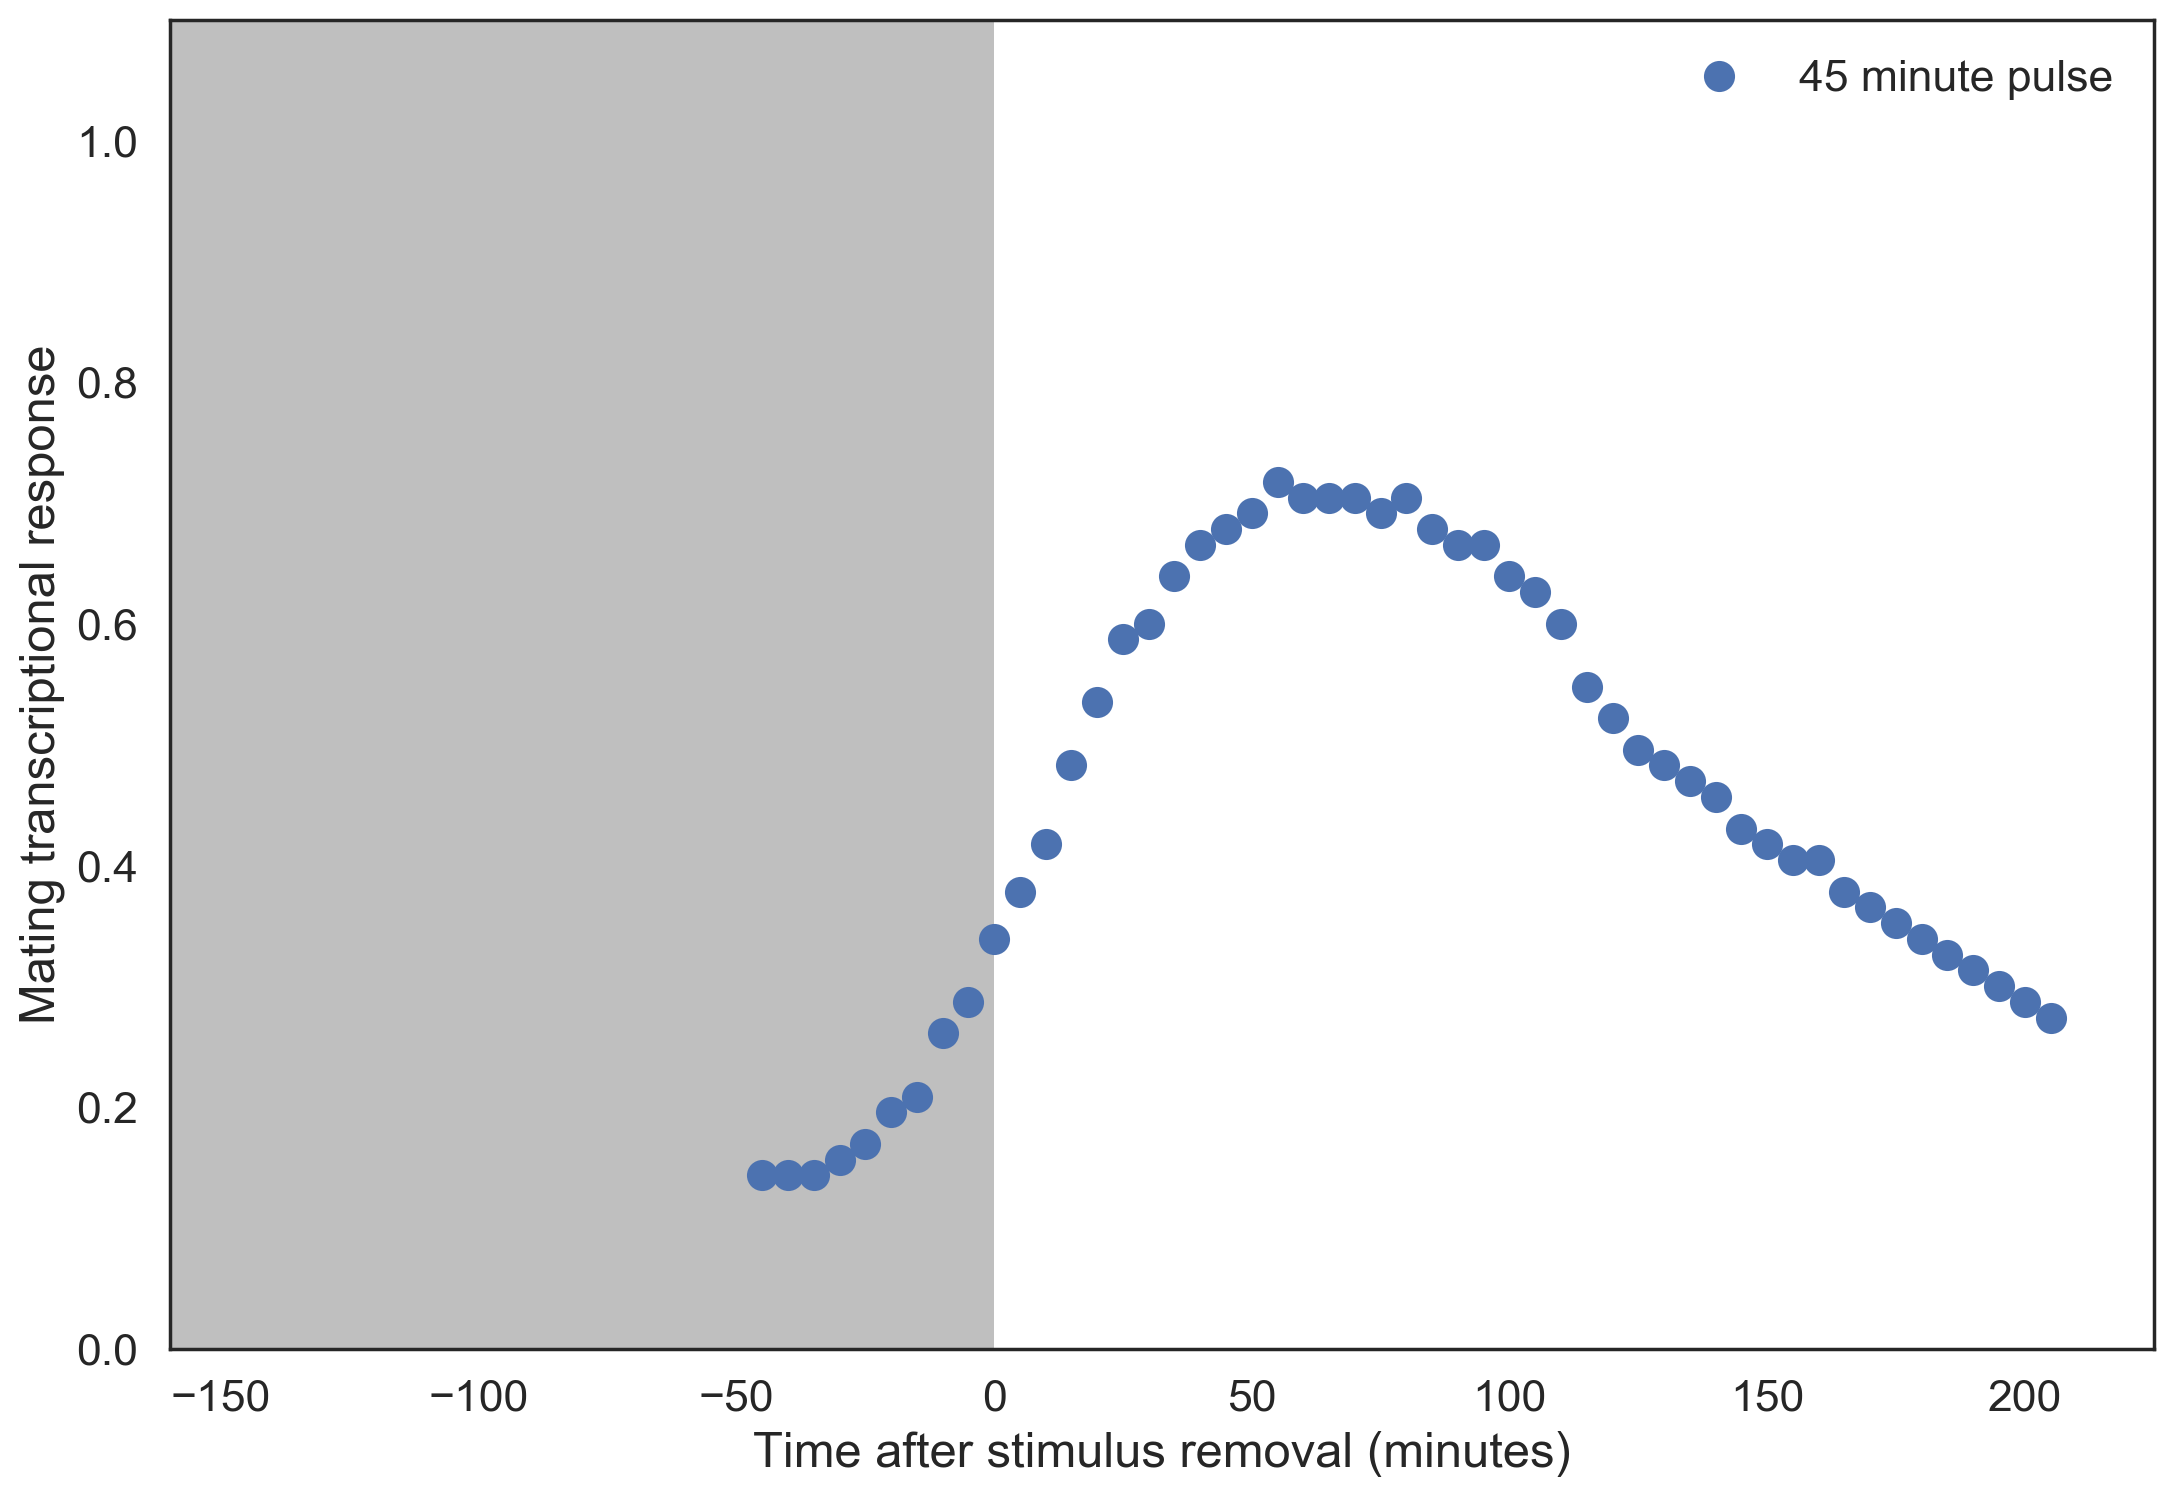

In [24]:
# Generate figure
sns.set_context("poster")
single_time = pulse50_time
single_data = pulse50_data
plt.plot(single_time[1]-45,single_data[1],'o')
# plt.plot(single_time[2]-60,single_data[2],'o')
# plt.plot(single_time[3]-75,single_data[3],'o')
# plt.plot(single_time[4]-90,single_data[4],'o')
# plt.plot(single_time[5]-160,single_data[5],'o')
plt.legend(["45 minute pulse","60 minute pulse","75 minute pulse","90 minute pulse","160 minute pulse"])
plt.xlabel("Time after stimulus removal (minutes)")
plt.ylabel("Mating transcriptional response")
plt.fill_between([-180,0], 0, 1.2, facecolor='gray', alpha=0.5)
plt.xlim([-160,225])
plt.ylim([0,1.1])
plt.savefig('/Users/AmyAllen/Documents/ThesisWork/ModelSelection/modelingEA/Figures/SinglePulseData45.jpg')